In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

df = pd.read_csv("tm_weak_labeled_data.csv") 

df = df[df["weak_label"] >= 0]

features = ["similarity", "city_match", "segment_match_score", "genre_match_score", "date_match", "price_score"] 
X = df[features]
y = df["weak_label"]
groups = df["query_id"]

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
group_train = groups.iloc[train_idx]
group_test = groups.iloc[test_idx]

train_group = group_train.value_counts(sort=False).sort_index().tolist()
test_group = group_test.value_counts(sort=False).sort_index().tolist()

dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(train_group)

dtest = xgb.DMatrix(X_test, label=y_test)
dtest.set_group(test_group)

params = {
    "objective": "rank:ndcg",
    "eval_metric": "ndcg",
    "learning_rate": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}

model = xgb.train(params, dtrain, num_boost_round=200)

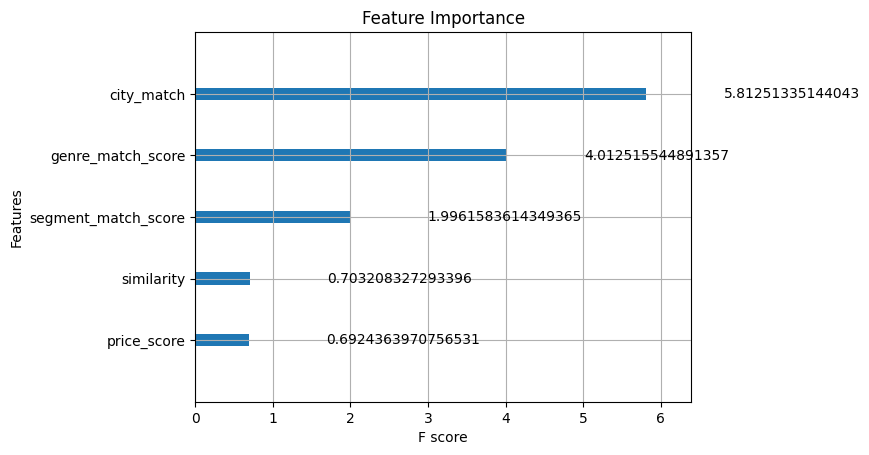

In [ ]:
import matplotlib.pyplot as plt

if model.num_boosted_rounds() > 0:
	xgb.plot_importance(model, importance_type='gain', max_num_features=30)
	plt.title("Feature Importance")
	plt.show()
else:
	print("The model does not contain any trees. Please ensure the model is trained properly.")

In [30]:
# Save the model
model.save_model("tm_lambdamart_ranking_model.json")

# Predict ranking scores
y_pred = model.predict(dtest)

# Save predicted ranking
df_test = df.iloc[test_idx].copy()
df_test["predicted_score"] = y_pred
df_test = df_test.sort_values(by=["query_id", "predicted_score"], ascending=[True, False])

# Save to CSV
df_test.to_csv("tm_ranked_results.csv", index=False)

In [31]:
evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=10
)

[0]	train-ndcg:0.94435	test-ndcg:0.93750
[10]	train-ndcg:1.00000	test-ndcg:1.00000
[17]	train-ndcg:1.00000	test-ndcg:1.00000


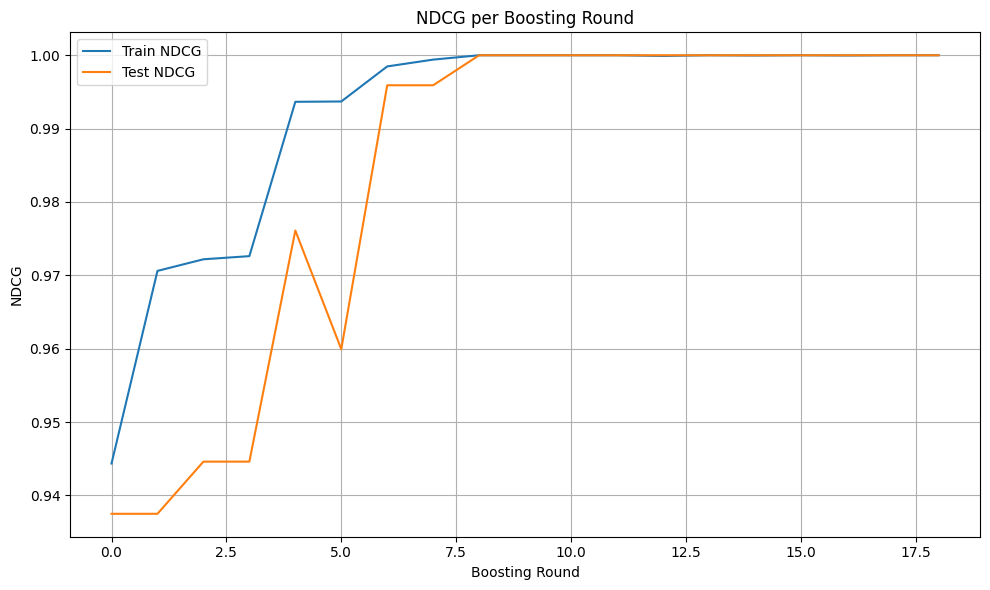

In [ ]:
import matplotlib.pyplot as plt

train_ndcg = evals_result["train"]["ndcg"]
test_ndcg = evals_result["test"]["ndcg"]

plt.figure(figsize=(10, 6))
plt.plot(train_ndcg, label="Train NDCG")
plt.plot(test_ndcg, label="Test NDCG")
plt.xlabel("Boosting Round")
plt.ylabel("NDCG")
plt.title("NDCG per Boosting Round")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
